# Prerequisites

- Stream ciphers

# Theory

RC4 (or ARC4) is a simple, fast stream cipher. Due to many vulnerabilities discovered it is proved to be insecure.

**Uses**
- Used in WEP (very insecure protocol).

Like all **stream ciphers** it generates a key stream and `xor`s it with the incoming plaintext to compute the ciphertext.
$$C = P \oplus KS$$

RC4 has 2 main algorithms: A key scheduling algorithm (KSA) and a pseudo random generation algorithm (PRGA)



### KSA
```python
def KSA(k):
    kl = len(k)
    # Init Sbox
    S = [i for i in range(256)] 
    # Scramble key
    j = 0
    for i in range(256):
        j = (j + S[i] + k[i % kl]) % 256
        S[i], S[j] = S[j], S[i]
```
The first step initializes the Sbox `| 0 | 1 | 2 | ... | 255 |`. Then we swap each position with a new position $j + 1$ calculated usint our sbox, key and old $j$.

Let's walk through 2 iterations. Suppose the first keybytes are `5 253`.  
We init our Sbox. For the first iteration `i = 0` we have `j = 0 + S[0] + K[0] = 0 + 0 + 5 = 5`

`| 0 | 1 | 2 | 3 | 4 | 5 | ... | 255 |`  
`| i |   |   |   |   | j | ... |     |`  
Then we swap  
`| 5 | 1 | 2 | 3 | 4 | 0 | ... | 255 |`  
`| i |   |   |   |   | j | ... |     |`

We increment `i`. the new  `j = 5 + S[1] + K[1] = 5 + 1 + 253 = 259 = 3 % 256`  
`| 5 | 1 | 2 | 3 | 4 | 0 | ... | 255 |`  
`|   | i |   | j |   |   | ... |     |`  
Then we swap
`| 5 | 3 | 2 | 1 | 4 | 0 | ... | 255 |`  
`|   | i |   | j |   |   | ... |     |`  



### PRGA
```python
def PRGA():
    i = old_i
    j = old_j

    i = (i+1) % 256
    j = (j + S[i]) % 256
    S[i], S[j] =  S[j], S[i]
    K = S[(S[i] + S[j]) % 256]

    old_i = i
    old_j = j

    return K
```

From wikipedia:

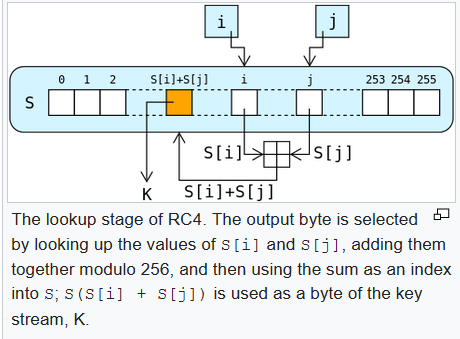

# Code

In [1]:
from Crypto.Cipher import ARC4
from Crypto.Util.number import inverse
import os

In [2]:
# Utils
def xor(a, b):
    return bytes([x^y for x,y in zip(a,b)])

In [10]:
# A class
class RC4:
    def __init__(self, key):
        self.k = key
        self.kl = len(key) # Key length
        self.i = 0
        self.j = 0
        assert(self.kl < 256)
        self.KSA()
        
    def KSA(self):
        # Init Sbox
        self.S = [i for i in range(256)] 
        # Scramble key
        j = 0
        for i in range(256):
            j = (j + self.S[i] + self.k[i % self.kl]) % 256
            self.S[i], self.S[j] = self.S[j], self.S[i]
        
    def PRGA(self):
        i = self.i
        j = self.j
        
        i = (i+1) % 256
        j = (j + self.S[i]) % 256
        self.S[i], self.S[j] =  self.S[j], self.S[i]
        K = self.S[(self.S[i] + self.S[j]) % 256]
        
        self.i = i
        self.j = j
        
        return K
        
    def encrypt(self, plaintext):
        keystream = [self.PRGA() for _ in range(len(plaintext))]
        enc = xor(plaintext, keystream)
        return enc    
    def decrypt(self, ciphertext):
        return self.encrypt(ciphertext)

In [11]:
secret = b'secret_key'
nonce =  os.urandom(16)

plaintext = b'secret_message'

In [14]:
rc4 = RC4(nonce + secret)
ciphertext = rc4.encrypt(plaintext)
print(ciphertext)

rc4 = RC4(nonce + secret)
print(rc4.decrypt(ciphertext))

b'/R\t!\xa8\xba\x988_\x86=\xc4#@'
b'secret_message'


In [15]:
# Library 
arc4 = ARC4.new(nonce + secret)
ciphertext = arc4.encrypt(plaintext)
print(ciphertext)
arc4 = ARC4.new(nonce + secret)
arc4.decrypt(ciphertext)

b'/R\t!\xa8\xba\x988_\x86=\xc4#@'


b'secret_message'

# The FMS attack

- [fms paper](https://link.springer.com/content/pdf/10.1007%2F3-540-45537-X_1.pdf)
- https://www.youtube.com/watch?v=2o3Hs-JDWLs
- [new iv form](https://www.sciencedirect.com/science/article/pii/S1877050921005603)

Many implementations of RC4 simply concatenate some IV to the some secret key `key = IV + secret`. This gives rise to *related key attacks* like the one we will explore here. This attack broke the WEP standard

This attack tries to use weak IVs and a reused key to expose the key. There are different forms for the weak IVs but the one we'll explot is `(A + 3, 255, v)` where `A` is the byte of the `secret` we try to extract.

The papers + video I linked above explain why this form works.  
TLDR: The proposed IV form transforms the Sbox in such a way that we can compute a byte of the secret key. This is a statistical attack

In [17]:
secret = b'very_secret_key'

In [18]:
secret_decr = []
sl = len(secret) # assume you know the secret length 
for A in range(sl):
    probs = [0] * 256 # init a frequency array 
    for v in range(256): # for each custom byte
        plaintext = b'A' * (A + 3) # doesn't matter the plaintext
        nonce = bytes([A+3, 255, v]) # weak nonce (L, n-1, v)
        
        ciphertext = ARC4.new(nonce + secret).encrypt(plaintext) # this line is send to the oracle and we receive the ciphertext
        
        keystream = xor(plaintext, ciphertext) # compute the keystream

        # simulate first known rounds to get j
        key = nonce + bytes(secret_decr)
        Sbox = [i for i in range(256)]  # init sbox
        j = 0
        for i in range(A + 3): # A + 3 because we know the first 3 bytes from nonce
            j = (j + Sbox[i] + key[i % len(key)]) % 256
            Sbox[i], Sbox[j] = Sbox[j], Sbox[i]
            if i == 1:
                o0, o1 = Sbox[0], Sbox[1] # keep original 2 values to filter for swaps

        # Resolved condition
        i = A + 3
        if Sbox[1] < i and Sbox[1] + Sbox[Sbox[1]] == A + 3:
            if (o0 != Sbox[0] or o1 != Sbox[1]): # check for swaps
                continue
            key_byte = (keystream[0] - j - Sbox[i]) % 256 # first byte of the keystream is K3 = first byte of the key. Follow the equation
            probs[key_byte] += 1
    secret_decr.append(probs.index(max(probs))) # argmax from the array of probs
    print(bytes(secret_decr))
            
        
    
            
        
    

b'v'
b've'
b'ver'
b'very'
b'very_'
b'very_s'
b'very_se'
b'very_sec'
b'very_secr'
b'very_secre'
b'very_secret'
b'very_secret_'
b'very_secret_k'
b'very_secret_ke'
b'very_secret_key'


# Resources

- [rc4 wiki](https://en.wikipedia.org/wiki/RC4)
- [fms wiki](https://en.wikipedia.org/wiki/Fluhrer,_Mantin_and_Shamir_attack)
- https://www.youtube.com/watch?v=2o3Hs-JDWLs
